In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import glob

In [2]:
def drop_outlier(array,count,bins):
    index = []
    range_ = np.arange(1,count,bins)
    for i in range_[:-1]:
        array_lim = array[i:i+bins]
        sigma = np.std(array_lim)
        mean = np.mean(array_lim)
        th_max,th_min = mean + sigma*2, mean - sigma*2
        idx = np.where((array_lim < th_max) & (array_lim > th_min))
        idx = idx[0] + i
        index.extend(list(idx))
    return np.array(index)

### 从 xlsx 文件中提取信息

In [7]:
Battery_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']

dir_path = 'dataset/'
Battery = {}
for name in Battery_list:
    print('Load Dataset ' + name + ' ...')
    path = glob.glob(dir_path + name + '/*.xlsx')
    dates = []
    for p in path:
        df = pd.read_excel(p, sheet_name=1)
        print('Load ' + str(p) + ' ...')
        dates.append(df['Date_Time'][0])
    idx = np.argsort(dates)
    path_sorted = np.array(path)[idx]
    
    count = 0
    discharge_capacities = []
    health_indicator = []
    internal_resistance = []
    CCCT = []
    CVCT = []
    for p in path_sorted:
        df = pd.read_excel(p,sheet_name=1)
        print('Load ' + str(p) + ' ...')
        cycles = list(set(df['Cycle_Index']))
        for c in cycles:
            df_lim = df[df['Cycle_Index'] == c]
            #Charging
            df_c = df_lim[(df_lim['Step_Index'] == 2)|(df_lim['Step_Index'] == 4)]
            c_v = df_c['Voltage(V)']
            c_c = df_c['Current(A)']
            c_t = df_c['Test_Time(s)']
            #CC or CV
            df_cc = df_lim[df_lim['Step_Index'] == 2]
            df_cv = df_lim[df_lim['Step_Index'] == 4]
            CCCT.append(np.max(df_cc['Test_Time(s)'])-np.min(df_cc['Test_Time(s)']))
            CVCT.append(np.max(df_cv['Test_Time(s)'])-np.min(df_cv['Test_Time(s)']))

            #Discharging
            df_d = df_lim[df_lim['Step_Index'] == 7]
            d_v = df_d['Voltage(V)']
            d_c = df_d['Current(A)']
            d_t = df_d['Test_Time(s)']
            d_im = df_d['Internal_Resistance(Ohm)']

            if(len(list(d_c)) != 0):
                time_diff = np.diff(list(d_t))
                d_c = np.array(list(d_c))[1:]
                discharge_capacity = time_diff*d_c/3600 # Q = A*h
                discharge_capacity = [np.sum(discharge_capacity[:n]) for n in range(discharge_capacity.shape[0])]
                discharge_capacities.append(-1*discharge_capacity[-1])

                dec = np.abs(np.array(d_v) - 3.8)[1:]
                start = np.array(discharge_capacity)[np.argmin(dec)]
                dec = np.abs(np.array(d_v) - 3.4)[1:]
                end = np.array(discharge_capacity)[np.argmin(dec)]
                health_indicator.append(-1 * (end - start))

                internal_resistance.append(np.mean(np.array(d_im)))
                count += 1

    discharge_capacities = np.array(discharge_capacities)
    health_indicator = np.array(health_indicator)
    internal_resistance = np.array(internal_resistance)
    CCCT = np.array(CCCT)
    CVCT = np.array(CVCT)
    
    idx = drop_outlier(discharge_capacities, count, 40)
    df_result = pd.DataFrame({'cycle':np.linspace(1,idx.shape[0],idx.shape[0]),
                              'capacity':discharge_capacities[idx],
                              'SoH':health_indicator[idx],
                              'resistance':internal_resistance[idx],
                              'CCCT':CCCT[idx],
                              'CVCT':CVCT[idx]})
    Battery[name] = df_result

Load Dataset CS2_35 ...
Load dataset/CS2_35\CS2_35_10_15_10.xlsx ...
Load dataset/CS2_35\CS2_35_10_22_10.xlsx ...
Load dataset/CS2_35\CS2_35_10_29_10.xlsx ...
Load dataset/CS2_35\CS2_35_11_01_10.xlsx ...
Load dataset/CS2_35\CS2_35_11_08_10.xlsx ...
Load dataset/CS2_35\CS2_35_11_23_10.xlsx ...
Load dataset/CS2_35\CS2_35_11_24_10.xlsx ...
Load dataset/CS2_35\CS2_35_12_06_10.xlsx ...
Load dataset/CS2_35\CS2_35_12_13_10.xlsx ...
Load dataset/CS2_35\CS2_35_12_20_10.xlsx ...
Load dataset/CS2_35\CS2_35_12_23_10.xlsx ...
Load dataset/CS2_35\CS2_35_1_10_11.xlsx ...
Load dataset/CS2_35\CS2_35_1_18_11.xlsx ...
Load dataset/CS2_35\CS2_35_1_24_11.xlsx ...
Load dataset/CS2_35\CS2_35_1_28_11.xlsx ...
Load dataset/CS2_35\CS2_35_2_10_11.xlsx ...
Load dataset/CS2_35\CS2_35_2_4_11.xlsx ...
Load dataset/CS2_35\CS2_35_8_17_10.xlsx ...
Load dataset/CS2_35\CS2_35_8_18_10.xlsx ...
Load dataset/CS2_35\CS2_35_8_19_10.xlsx ...
Load dataset/CS2_35\CS2_35_8_30_10.xlsx ...
Load dataset/CS2_35\CS2_35_9_21_10.xlsx ..

### 如果上面的读取数据集失败，可以通过下面的方式加载已提取出来的数据

In [ ]:
Battery_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']
Battery = np.load('dataset/CALCE.npy', allow_pickle=True)
Battery = Battery.item()

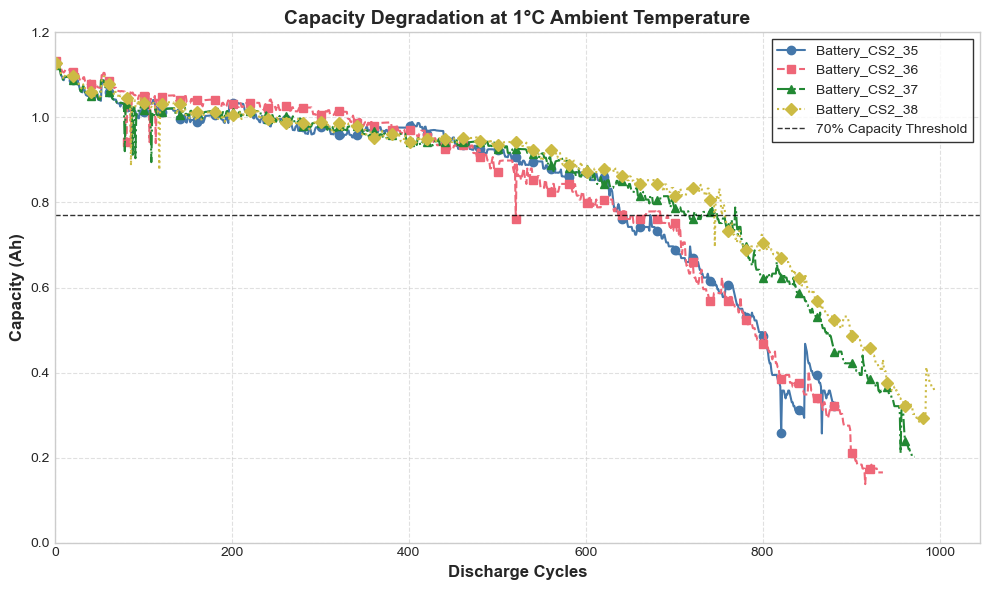

In [8]:
# Rated_Capacity = 1.1
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 设置科研风格
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("colorblind")  # 使用色盲友好配色

fig, ax = plt.subplots(1, figsize=(10, 6))

# 使用更科学的颜色和线型组合
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'D']
colors = ['#4477AA', '#EE6677', '#228833', '#CCBB44']  # 高对比度配色

for i, (name, style) in enumerate(zip(Battery_list, line_styles)):
    battery = Battery[name]
    ax.plot(battery['cycle'], battery['capacity'], 
            color=colors[i % len(colors)],
            linestyle=style,
            marker=markers[i % len(markers)],
            markevery=20,  # 每隔20个点显示一个标记
            markersize=6,
            linewidth=1.5,
            label=f'Battery_{name}')

# 添加容量阈值线
ax.axhline(y=1.1*0.7, color='k', linestyle='--', alpha=0.8, linewidth=1, label='70% Capacity Threshold')

# 设置标签和标题
ax.set_xlabel('Discharge Cycles', fontsize=12, fontweight='bold')
ax.set_ylabel('Capacity (Ah)', fontsize=12, fontweight='bold')
ax.set_title('Capacity Degradation at 1°C Ambient Temperature', fontsize=14, fontweight='bold')

# 设置图例
ax.legend(frameon=True, fancybox=False, edgecolor='black', fontsize=10)

# 设置坐标轴
ax.tick_params(axis='both', which='major', labelsize=10)
ax.set_xlim(0, None)
ax.set_ylim(0, 1.2)  # 根据实际数据调整

# 添加网格
ax.grid(True, linestyle='--', alpha=0.6)

# 优化布局
plt.tight_layout()

plt.show()

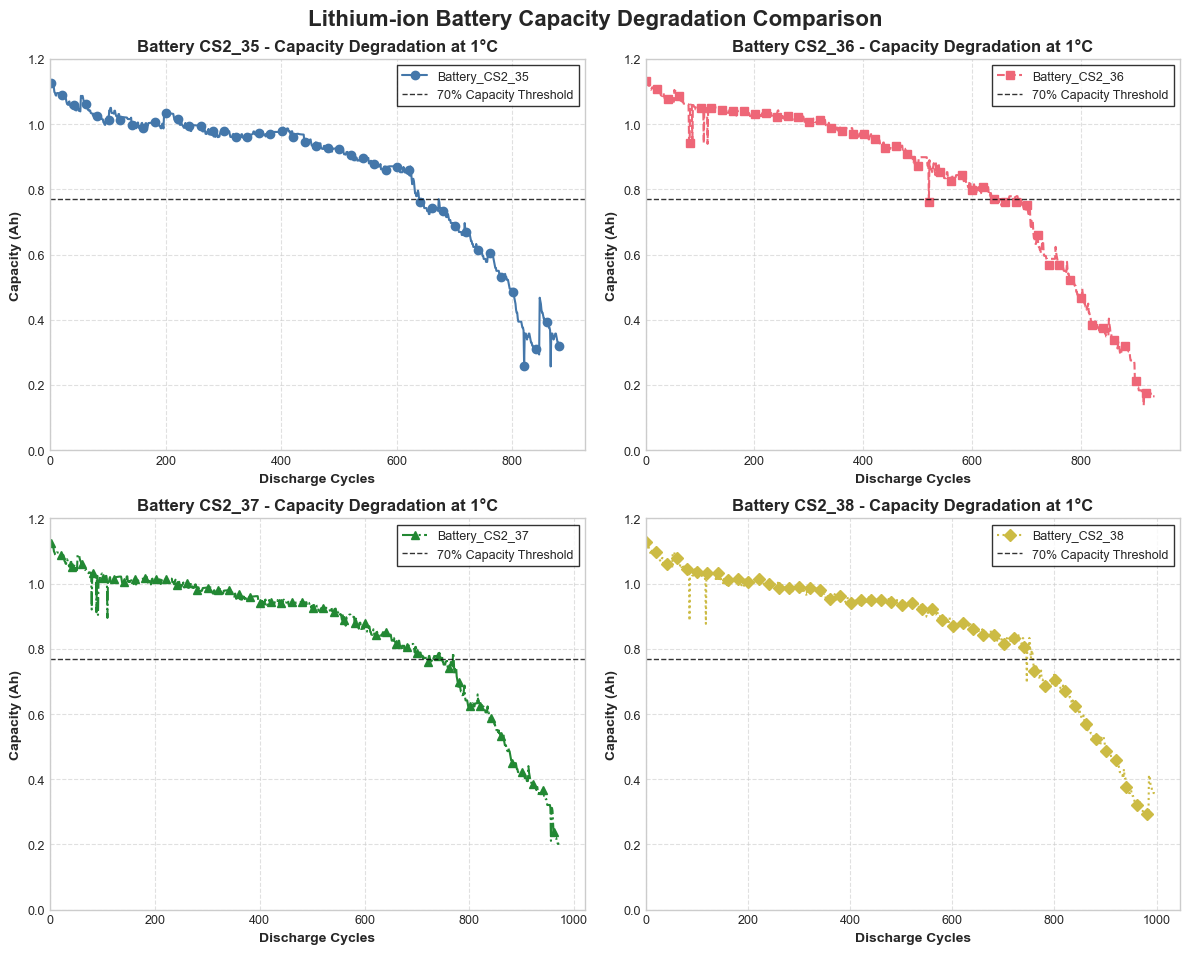

In [9]:
# Rated_Capacity = 1.1
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 设置科研风格
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("colorblind")  # 使用色盲友好配色

# 创建2x2的子图布局
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # 将二维数组展平为一维，便于循环

# 使用更科学的颜色和线型组合
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'D']
colors = ['#4477AA', '#EE6677', '#228833', '#CCBB44']  # 高对比度配色

# 确保Battery_list有4个电池（根据实际情况调整）
for i, name in enumerate(Battery_list):
    if i >= 4:  # 如果超过4个电池，只显示前4个
        break
        
    battery = Battery[name]
    ax = axes[i]
    
    # 绘制当前电池的容量衰减曲线
    ax.plot(battery['cycle'], battery['capacity'], 
            color=colors[i % len(colors)],
            linestyle=line_styles[i % len(line_styles)],
            marker=markers[i % len(markers)],
            markevery=20,  # 每隔20个点显示一个标记
            markersize=6,
            linewidth=1.5,
            label=f'Battery_{name}')

    # 添加容量阈值线
    ax.axhline(y=1.1*0.7, color='k', linestyle='--', alpha=0.8, linewidth=1, label='70% Capacity Threshold')

    # 设置每个子图的标签和标题
    ax.set_xlabel('Discharge Cycles', fontsize=10, fontweight='bold')
    ax.set_ylabel('Capacity (Ah)', fontsize=10, fontweight='bold')
    ax.set_title(f'Battery {name} - Capacity Degradation at 1°C', fontsize=12, fontweight='bold')

    # 设置图例
    ax.legend(frameon=True, fancybox=False, edgecolor='black', fontsize=9)

    # 设置坐标轴
    ax.tick_params(axis='both', which='major', labelsize=9)
    ax.set_xlim(0, None)
    ax.set_ylim(0, 1.2)  # 根据实际数据调整

    # 添加网格
    ax.grid(True, linestyle='--', alpha=0.6)

# 如果电池数量不足4个，隐藏多余的子图
for i in range(len(Battery_list), 4):
    axes[i].set_visible(False)

# 添加总标题（可选）
fig.suptitle('Lithium-ion Battery Capacity Degradation Comparison', 
             fontsize=16, fontweight='bold', y=0.95)

# 优化布局
plt.tight_layout()
plt.subplots_adjust(top=0.90)  # 为总标题留出空间

plt.show()

### 放电容量 v.s. 放电周期

In [ ]:
#Rated_Capacity = 1.1
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c:']
for name,color in zip(Battery_list, color_list):
    battery = Battery[name]
    ax.plot(battery['cycle'], battery['capacity'], color, label='Battery_'+name)
#plt.plot([-1,1000],[Rated_Capacity*0.7, Rated_Capacity*0.7], c='black', lw=1, ls='--')  # 临界点直线
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 1°C')
plt.legend()

### 放电容量和内阻变化

Text(0, 0.5, 'State of Health')

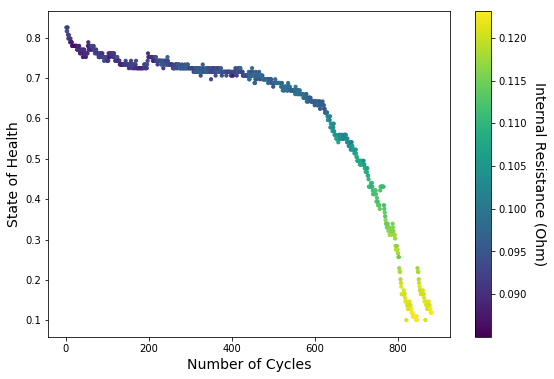

In [5]:
battery = Battery['CS2_35']
plt.figure(figsize=(9,6))
plt.scatter(battery['cycle'], battery['SoH'], c=battery['resistance'], s=10)
cbar = plt.colorbar()
cbar.set_label('Internal Resistance (Ohm)', fontsize=14, rotation=-90, labelpad=20)
plt.xlabel('Number of Cycles', fontsize=14)
plt.ylabel('State of Health', fontsize=14)

### 各项指标 v.s. 充放电周期

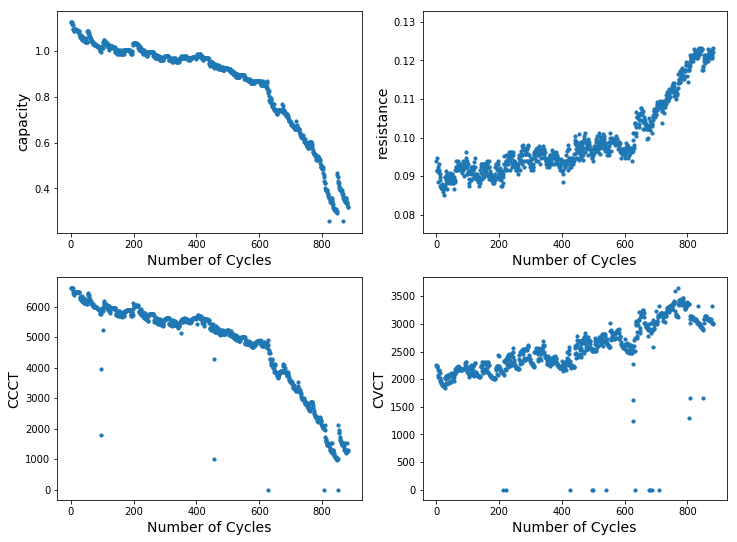

In [6]:
battery = Battery['CS2_35']
plt.figure(figsize=(12,9))
names = ['capacity', 'resistance', 'CCCT', 'CVCT']
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.scatter(battery['cycle'], battery[names[i]], s=10)
    plt.xlabel('Number of Cycles', fontsize=14)
    plt.ylabel(names[i], fontsize=14)